In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib.colors as mcolors

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_preprocessing import haversine
from others import spearman_corr, MSE, MBE

## Compare Satellite data with OBS

## Load SAT data

In [2]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy' # Dont works

yy_s, yy_e = 2002, 2022
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
# lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')

Read json file   : IMERG_1dy.json


In [5]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy')

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

SAT_time = pd.to_datetime(PRE_data['time'].data)

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)
PRE = PRE_data['PRE'].data

# PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

del PRE_data

print(f'PRE shape: {PRE.shape}')

Reading data: IMERG_Italy_1dy_2000_06_01_2024_02_29.nc
PRE shape: (7670, 25, 30)


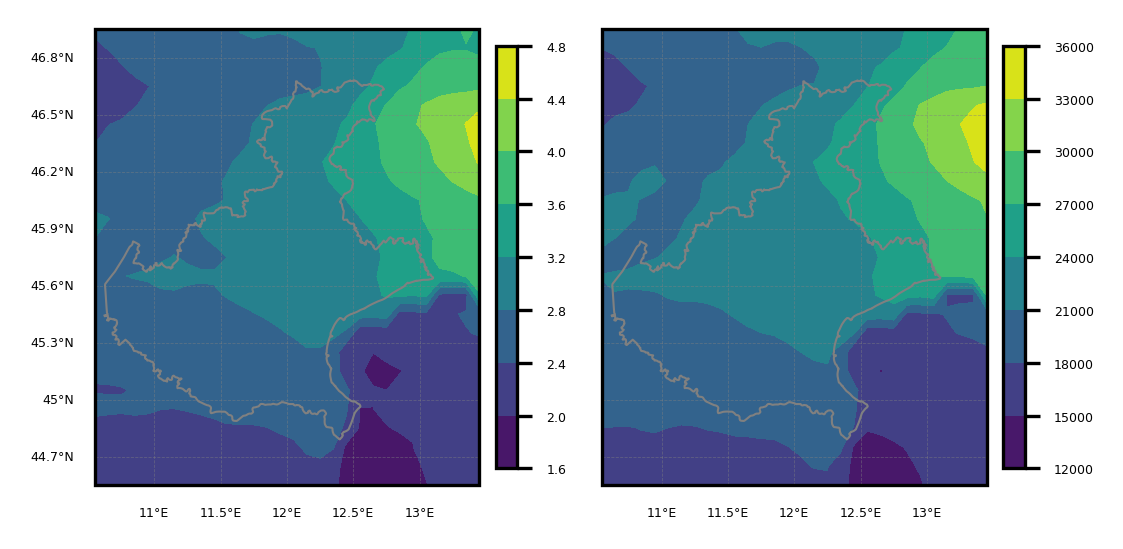

In [7]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d, lat2d, s=1, c='k')

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(PRE,axis=0))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d, lat2d, s=1, c='k')

a1 = ax1.contourf(lon2d, lat2d, np.nansum(PRE,axis=0))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=3)

## Load Raingauge Data

In [8]:
OBS_base = os.path.join(dir_base,'stations','data','Veneto','DATA')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Metadata_IT-340_Veneto_all.csv')

if os.path.exists(OBS_INFO_dir):
    OBS_INFO = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

OBS_INFO = OBS_INFO[(OBS_INFO['Year_Start'] <= yy_s)&(OBS_INFO['Year_End'] >= yy_e)]
OBS_INFO = OBS_INFO.reset_index(drop=True, inplace=False)
print(f'Number of stations: {OBS_INFO.shape[0]}')

Number of stations: 156


In [9]:
MSE_VAL, MBE_VAL, COR_VAL = [], [], []
lon_ref, lat_ref = [], []
for pos in range(len(OBS_INFO)):

    data = pd.read_csv(os.path.join(OBS_base,time_reso,OBS_INFO.File[pos]))

    if time_reso == '3h':
        start = f'{yy_s}-01-01 00:00'
        end = f'{yy_e}-12-31 23:59'
    elif time_reso == '1dy':
        start = f'{yy_s}-01-01'
        end = f'{yy_e}-12-31'
    data_filtered = data[(data['TIME'] >= start) & (data['TIME'] <= end)]
    data_filtered = data_filtered.reset_index(drop=True)
    PRE_obs = data_filtered['PRE'].values

    lat_obs = OBS_INFO.Lat[pos]
    lon_obs = OBS_INFO.Lon[pos]
    lon_ref.append(lon_obs)
    lat_ref.append(lat_obs)

    distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PRE_sat = PRE[:,min_index[0],min_index[1]]

    DATA_pd = pd.DataFrame({'Time':SAT_time, 'OBS':PRE_obs, 'SAT':PRE_sat})
    DATA_pd['Time'] = pd.to_datetime(DATA_pd['Time'])
    DATA_pd = DATA_pd.dropna(subset=['SAT', 'OBS'])

    mse_ = MSE(DATA_pd['SAT'].values, DATA_pd['OBS'].values)
    MSE_VAL.append(float(mse_))
    
    cor_ = spearman_corr(DATA_pd['SAT'].values, DATA_pd['OBS'].values)
    COR_VAL.append(float(cor_))    
    
    MBE_ = MBE(DATA_pd['SAT'].values, DATA_pd['OBS'].values)
    MBE_VAL.append(float(MBE_))

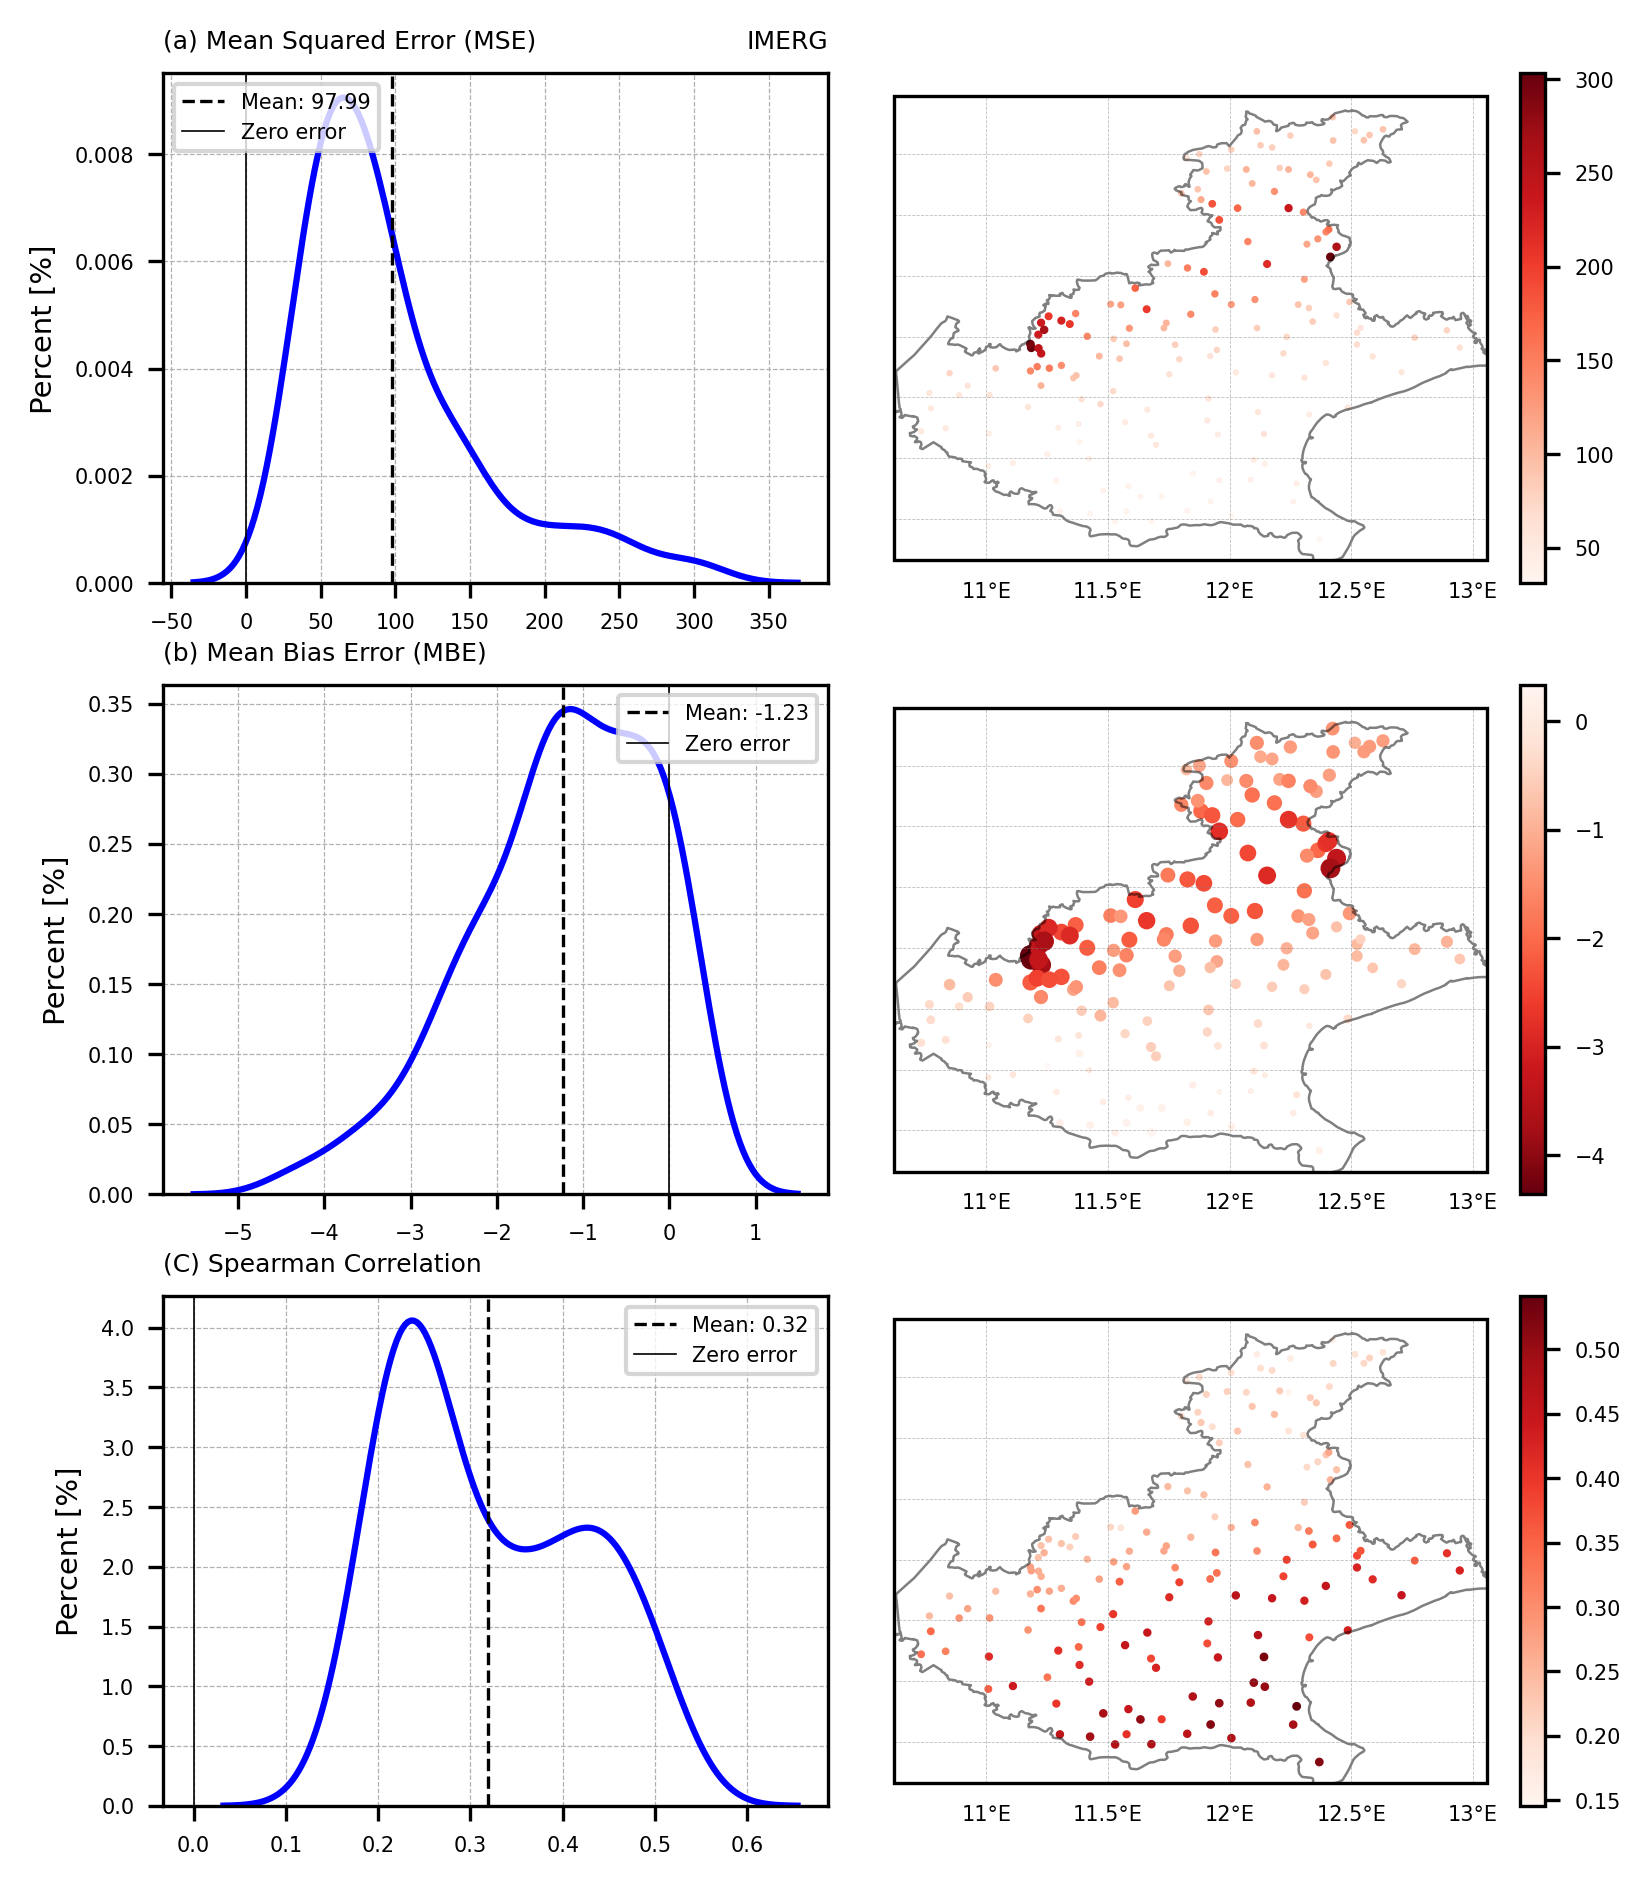

In [11]:
levels = np.arange(0, 6, 1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Reds
cmap_r = plt.cm.Reds_r

fig = plt.figure(figsize=(6,7.5),dpi=300)
gs = gridspec.GridSpec(3,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(MSE_VAL,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(MSE_VAL),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(MSE_VAL),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(-0.1,3.1)
# ax1.set_ylim(0,1.4)
# ax1.set_xticks(np.arange(0, 3.1, 0.5))
# ax1.set_xticklabels([])
ax1.set_title('(a) Mean Squared Error (MSE)', loc='left', fontsize=6)
ax1.set_title(product, loc='right', fontsize=6)
ax1.legend(fontsize=5,loc=2)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_geometries(VENETO.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MSE_VAL/np.nanmax(MSE_VAL)),marker='.',c=MSE_VAL,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(MBE_VAL,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(MBE_VAL),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(MBE_VAL),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(-0.1,3.1)
# ax1.set_ylim(0,1.4)
# ax1.set_xticks(np.arange(0, 3.1, 0.5))
# ax1.set_xticklabels([])
ax1.set_title('(b) Mean Bias Error (MBE)', loc='left', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_geometries(VENETO.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MBE_VAL/np.nanmax(MBE_VAL)),marker='.',c=MBE_VAL,cmap=cmap_r,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[2, 0])
sns.kdeplot(COR_VAL,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(COR_VAL),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(COR_VAL),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(-0.1,3.1)
# ax1.set_ylim(0,1.4)
# ax1.set_xticks(np.arange(0, 3.1, 0.5))
# ax1.set_xticklabels([])
ax1.set_title('(C) Spearman Correlation', loc='left', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[2, 1], projection = proj)
ax1.add_geometries(VENETO.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(COR_VAL/np.nanmax(COR_VAL)),marker='.',c=COR_VAL,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)